In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


In [2]:
import os
import subprocess
import inspect

import math
import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh
import pickle as pkl

from src.depth import DepthPoset

import itertools

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines
from matplotlib.patches import Patch

from src.depth import DepthPoset


from tqdm import tqdm
from src.profiling import Timer

# Load and Format the Data

## Define Directories

In [3]:
# the directory to save pictures
path_to_save = 'raports/pics/torus-transpositions-extended'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

In [4]:
# the directory to load transpositions data
directory = "results/transpositions-during-linear-homotopy-between-extended-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

## Check sizes of files

In [5]:
def get_dim_and_n_from_torus_file(path):
    with open(path, 'rb') as file:
        res = pkl.load(file)
    return res['dim'], res['n']

/tmp/ipykernel_142008/3943854577.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses-extended/{path}.pkl')
Extracting the Dimensions and sizes of toruses: 100%|██████████| 71/71 [00:00<00:00, 393.33it/s]


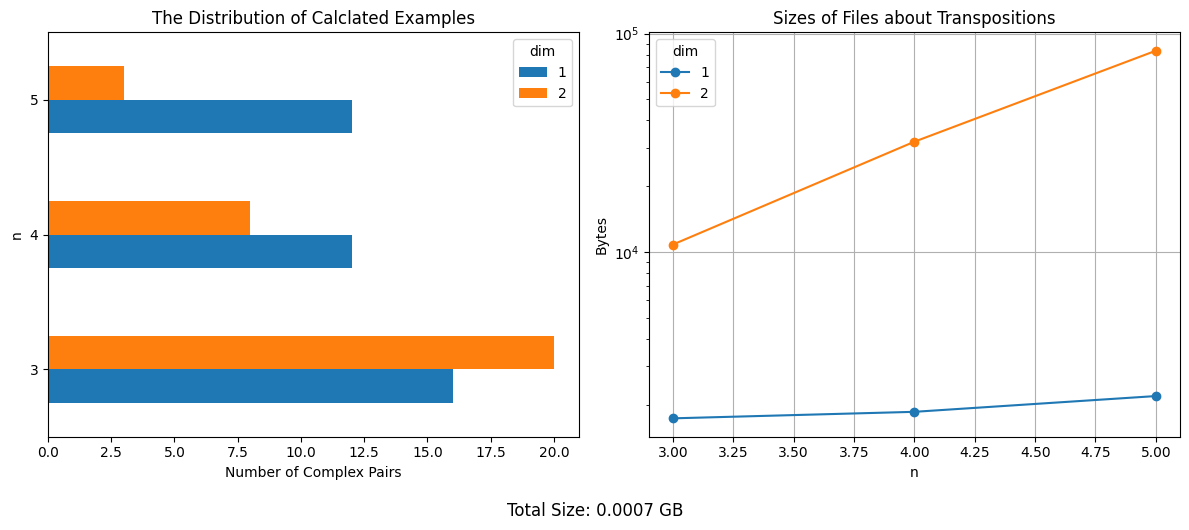

In [6]:
df_sizes = pd.DataFrame({'path': paths})
df_sizes['size'] = df_sizes['path'].apply(lambda path: os.path.getsize(path))
df_sizes['original_path0'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[0])
df_sizes['original_path1'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[1])
df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses-extended/{path}.pkl')
df_sizes['original_size0'] = df_sizes['original_path0'].apply(lambda path: os.path.getsize(path))
df_sizes['original_size1'] = df_sizes['original_path1'].apply(lambda path: os.path.getsize(path))
tqdm.pandas(desc='Extracting the Dimensions and sizes of toruses')
df_sizes['dim&n'] = df_sizes['original_path0'].progress_apply(lambda path: get_dim_and_n_from_torus_file(path))
df_sizes['dim'] = df_sizes['dim&n'].apply(lambda dimn: dimn[0])
df_sizes['n'] = df_sizes['dim&n'].apply(lambda dimn: dimn[1])
df_sizes = df_sizes.drop(columns='dim&n')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title('The Distribution of Calclated Examples')
df_sizes.groupby(['dim', 'n'])['path'].count().reset_index().pivot_table(columns='dim', index='n', values='path').fillna(0).astype(int).plot(kind='barh', ax=axs[0])
axs[0].set_xlabel('Number of Complex Pairs')

axs[1].set_title('Sizes of Files about Transpositions')
df_sizes.groupby(['dim', 'n'])['size'].mean().reset_index().pivot_table(columns='dim', index='n', values='size').plot(logy=True, marker='o', ax=axs[1])
axs[1].set_ylabel('Bytes')
axs[1].grid(True)

fig.text(0.5, -0.05, f"Total Size: {df_sizes['size'].sum()*1024**-3:.4f} GB", ha='center', va='bottom', fontsize='large')
plt.tight_layout()
plt.show()

## Load Transpositions Data

In [7]:
df = []
errs = {}
for path in tqdm(paths):
    if os.path.getsize(path) < np.inf*1024**2:
        try:
            with open(path, 'rb') as file:
                loaded_dict = pkl.load(file)
            loaded_dict['transpositions'].insert(0, 'complex_index0', loaded_dict['complex_index0'])
            loaded_dict['transpositions'].insert(1, 'complex_index1', loaded_dict['complex_index1'])
            loaded_dict['transpositions'].insert(2, 'complex_dim', loaded_dict['complex_dim'])
            loaded_dict['transpositions'].insert(3, 'complex_shape', [loaded_dict['complex_shape']]*len(loaded_dict['transpositions']))
            df.append(loaded_dict['transpositions'])

        except Exception as err:
            errs.update({path: err})
    else:
        errs.update({path: 'Giant file'})
errs = pd.Series(errs)
if len(errs) > 0:
    errs_count = errs.astype(str).value_counts()
    print(f'There is some amount of errors:\n{errs_count.to_string(name=False)}\n')
    #for path in errs.index:
    #    if os.path.exists(path):
    #        os.remove(path)
    
df = pd.concat(df)

if not 'complex_n' in df.columns: 
    df.insert(3, 'complex_n', df['complex_shape'].apply(lambda x: x[0] if (np.array(x)[1:] == np.array(x)[:-1]).all() else None))

#print(f'There are {pd.isna(df['transposition']).sum()} empty transposition values in {len(df)} lines')
#df = df[~pd.isna(df['transposition'])]
#df = df.join(df['transposition'].apply(lambda tr: tr.to_dict()).apply(pd.Series))

print(f'df.shape = {df.shape}')
df.head()

100%|██████████| 71/71 [00:00<00:00, 951.60it/s]

df.shape = (7976, 26)


,complex_index0,complex_index1,complex_dim,complex_n,complex_shape,time,value,birth_relation_cell_similarity,death_relation_cell_similarity,poset_closure_arcs_cell_similarity,...,type,switch,birth_relation_index_similarity,death_relation_index_similarity,poset_arc_cell_similarity,poset_arc_index_similarity,poset_node_cell_similarity,poset_node_index_similarity,relation_cell_similarity,relation_index_similarity
0,2025-07-15 15:04:04.174861,2025-07-15 15:04:04.175381,1,3,"(3,)",0.212254,0.440044,0.0,1.0,0.0,...,birth-death,switch forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-07-15 15:04:04.174861,2025-07-15 15:04:04.175381,1,3,"(3,)",0.902510,1.114666,0.0,1.0,0.0,...,death-death,no switch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2025-07-15 15:04:04.174861,2025-07-15 15:04:04.175559,1,3,"(3,)",0.243794,0.653974,1.0,1.0,1.0,...,birth-birth,no switch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-07-15 15:04:04.174861,2025-07-15 15:04:04.175559,1,3,"(3,)",0.358076,1.375932,1.0,1.0,1.0,...,death-death,no switch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-07-15 15:04:04.174861,2025-07-15 15:04:04.175559,1,3,"(3,)",0.603931,1.572872,1.0,0.0,0.0,...,birth-death,switch forward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


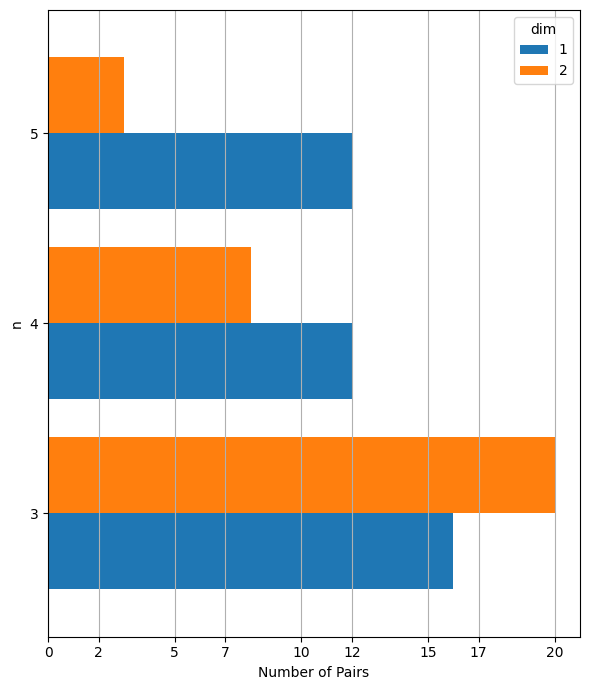

In [8]:
fig, ax = plt.subplots(figsize=(6, 7))

df_to_plot = df.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n'])['index 0'].count().reset_index().groupby(['complex_dim', 'complex_n']
            )['complex_index0'].count().reset_index().rename(columns=lambda s: s.replace('complex_', '')).pivot_table(columns='dim', index='n', values='index0').fillna(0).astype(int)
df_to_plot.plot(kind='barh', width=0.8, ax=ax)

ax.set_xlabel('Number of Pairs')

xticks = ax.get_xticks()
xticks = np.unique(np.append(xticks[xticks <= df_to_plot.max().max()], df_to_plot.max().max())).astype(int)

ax.set_xticks(xticks)

ax.grid(axis='x')

plt.tight_layout()

plt.savefig(os.path.join(path_to_save, 'distribution.png'))

# Switch Types Distribution

In [9]:
tqdm.pandas(desc="Define switch type from type and switch columns")
df['switch type'] = df.progress_apply(lambda row: row['type'] if row['switch'] in ['switch', 'switch backward', 'switch forward'] else row['switch'], axis=1)

df['switch type'].value_counts()

Define switch type from type and switch columns: 100%|██████████| 7976/7976 [00:00<00:00, 120101.85it/s]


switch type
no switch      6735
birth-birth     515
birth-death     400
death-death     326
Name: count, dtype: int64

In [10]:
# define colors and markers
switch_type_colors = pd.Series({
    'no switch': '#000000',    # black
    'birth-birth': '#0072B2',  # blue (CUD-safe)
    'birth-death': '#E69F00',  # orange (CUD-safe)
    'death-death': '#CC79A7',  # purple/pinkish (CUD-safe)
}, name='color')
switch_type_markers = pd.Series({
    'no switch': 'o',
    'birth-birth': '^',
    'birth-death': 'X',
    'death-death': 'v',
}, name='marker')

pd.DataFrame([switch_type_colors, switch_type_markers])

,no switch,birth-birth,birth-death,death-death
color,#000000,#0072B2,#E69F00,#CC79A7
marker,o,^,X,v


In [11]:
df_switch_types = df.copy()

with Timer() as timer:
    df_switch_types = df_switch_types.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n', 'dim', 'switch type'])['index 0'].count().reset_index().rename(columns={'index 0': 'count'})
    print(f'Calculated counts-values for each type in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()
    
    df_switch_types_mean = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].mean().reset_index()
    df_switch_types_mean = df_switch_types_mean.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')
    df_switch_types_mean.index.name = 'n'
    print(f'Calculated mean count in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()
    

    df_switch_types_std = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].std().reset_index()
    df_switch_types_std = df_switch_types_std.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')
    df_switch_types_std.index.name = 'n'
    print(f'Calculated variation count in {timer.elapsed():.4f} seconds.')

df_switch_types_mean = df_switch_types_mean.sort_index(axis=1)
df_switch_types_std = df_switch_types_std.sort_index(axis=1)

complex_dims = pd.unique(df['complex_dim'])
transposition_dims = pd.unique(df['dim'])

print()
print(f'df_switch_types_std.shape = {df_switch_types_std.shape}')
print('...\n')
print(f'df_switch_types_mean.shape = {df_switch_types_mean.shape}')
df_switch_types_mean.head()


Calculated counts-values for each type in 0.0046 seconds.
Calculated mean count in 0.0045 seconds.
Calculated variation count in 0.0045 seconds.

df_switch_types_std.shape = (3, 16)
...

df_switch_types_mean.shape = (3, 16)


complex_dim           1                                                \
dim                   0                                 1               
switch type birth-birth birth-death no switch birth-death death-death   
n                                                                       
3              1.000000       1.125  1.000000    1.222222         1.0   
4              1.100000       1.300  1.600000    1.250000         1.0   
5              1.833333       1.375  2.916667    1.300000         1.6   

complex_dim                     2                                      \
dim                             0                                   1   
switch type no switch birth-birth birth-death   no switch birth-birth   
n                                                                       
3            1.000000    2.684211    1.214286   13.950000    8.500000   
4            1.727273    5.000000    2.250000   48.500000   14.625000   
5            2.818182    8.666667    3.333333  139.333333   29.666667   

complex_dim                                                              \
dim                                                       2               
switch type birth-death death-death   no switch birth-death death-death   
n                                                                         
3              5.200000    4.150000   58.850000    2.000000    2.631579   
4              9.000000    8.000000  199.875000    1.875000    4.500000   
5             18.333333   18.333333  566.333333    1.333333    5.666667   

complex_dim              
dim                      
switch type   no switch  
n                        
3             13.700000  
4             51.375000  
5            123.666667

In [12]:
pic_filename_template = 'transposition-types-complex-dim{complex_dim}-subposet-dim{dim}-drop-no-switches-{drop_no_switch}.png'

In [13]:
for irow, row in df_switch_types_mean.columns.to_frame()[['complex_dim', 'dim']].drop_duplicates().reset_index(drop=True).iterrows():
    complex_dim, dim = row
    for drop_no_switch in np.arange(2).astype(bool):
        row['drop_no_switch'] = drop_no_switch
        path = os.path.join(path_to_save, pic_filename_template.format(**row))
        df_this_mean = df_switch_types_mean[complex_dim][dim]
        df_this_std = df_switch_types_std[complex_dim][dim]

        if drop_no_switch:
            df_this_mean = df_this_mean.drop(columns='no switch')
            df_this_std = df_this_std.drop(columns='no switch')

        assert df_this_mean.columns.to_list() == df_this_std.columns.to_list()
        assert df_this_mean.index.to_list() == df_this_std.index.to_list()
        
        for col in df_this_mean.columns:
            x = df_this_mean.index.values
            y_mean = df_this_mean[col].values
            y_std = df_this_std[col].values
            plt.plot(x, y_mean, color=switch_type_colors[col], marker=switch_type_markers[col], label=col, linewidth=2, markersize=8, zorder=1)
            plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, color=switch_type_colors[col], zorder=0)

        plt.grid(True)
        plt.legend()
        plt.xlabel('$n$')
        plt.tight_layout()
        plt.savefig(path)
        plt.close()

In [14]:
figure_2_layers_template = r"""
\begin{{figure}}[htbp]
\centering
{level0}
\vspace{{0.5cm}}
{level1}
\caption{{{caption}}}
\label{{{label}}}
\end{{figure}}
""".strip()

subfigure_template = r"""
\begin{{subfigure}}[b]{{{figwidth}\textwidth}}
    \includegraphics[width=\linewidth]{{{path}}}
    \caption{{{caption}}}
    \label{{{label}}}
\end{{subfigure}}
""".strip()


In [15]:
switch_type_distributions_ltx = []

for complex_dim in pd.unique(df_switch_types['complex_dim']):
    figwidth = round(0.90/(complex_dim + 1), 2)

    subfigures_level0 = []
    subfigures_level1 = []
    
    for dim in range(complex_dim + 1):
        path = os.path.join(path_to_save, pic_filename_template.format(complex_dim=complex_dim, dim=dim, drop_no_switch=False))
        path = path.replace('raports/', '')
        caption = f"Cells dimension {dim}"
        label = f'fig:complex{complex_dim}cells{dim}'
        subfigures_level0.append(subfigure_template.format(figwidth=figwidth, path=path, caption=caption, label=label))

        path = os.path.join(path_to_save, pic_filename_template.format(complex_dim=complex_dim, dim=dim, drop_no_switch=True))
        path = path.replace('raports/', '')
        caption = f"Cells dimension {dim} (without no switch transpositions)"
        label = f'fig:complex{complex_dim}cells{dim}onlyswitch'
        subfigures_level1.append(subfigure_template.format(figwidth=figwidth, path=path, caption=caption, label=label))
    
    level0 = '\n\\hfill\n'.join(subfigures_level0)
    level1 = '\n\\hfill\n'.join(subfigures_level1)
    caption = f'The switch type distribution for $\\mathbb{{T}}_n^{{{complex_dim}}}$'
    label = f'typesdistribution{complex_dim}'
    switch_type_distributions_ltx.append(figure_2_layers_template.format(level0=level0, level1=level1, caption=caption, label=label))

switch_type_distributions_ltx = '\n\n'.join(switch_type_distributions_ltx)
#print(switch_type_distributions_ltx)

In [16]:
# load LaTeX template
with open('texts/template.tex', 'r') as file:
    ltx_latex = file.read()

In [17]:
body = f"""
\\section{{Switch Types Distributions}}
{switch_type_distributions_ltx}
"""

raport = ltx_latex.replace('BODY', body)

In [18]:
with open('raports/extended-barycentric-torus-transpositions.tex', 'w') as file:
    file.write(raport)



In [20]:
os.chdir('raports')
result = subprocess.run(
    ['pdflatex', 'extended-barycentric-torus-transpositions.tex'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)
os.chdir('..')